# Building the 1D CNN

### Import the relevant packages

In [17]:
%matplotlib inline
import context
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import subprocess
import sys
from tqdm import tqdm

import tensorflow as tf
# tf.get_variable('test_bool', 1, tf.bool)
from tensorflow.python.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import (Add, Concatenate, Input, Dense, 
                                            Dropout, Embedding, Conv1D, 
                                            MaxPooling1D, GlobalAveragePooling1D, 
                                            Flatten)
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import StratifiedKFold

ROOT_DIR = os.getcwd() + '/'
CHECKPOINTS_DIR = ROOT_DIR + 'checkpoints/'
build = context.build_promoter
construct = context.construct_neural_net
encode = context.encode_sequences
organize = context.organize_data

#### Define filename of input data

In [3]:
sample_filename = ('10000_from_20190612130111781831_percentiles_els_binarized_homogeneous_deflanked_'
                   'sequences_with_exp_levels.txt.gz')

#### Define the absolute path of this file

In [4]:
sample_path = ROOT_DIR + '../../../example/processed_data/' + sample_filename

### Encode sequences

In [5]:
X_padded, y_scaled, abs_max_el = encode.encode_sequences_with_method(sample_path, 
                                                                     method='One-Hot', 
                                                                     scale_els=True, 
                                                                     model_type='1DCNN', 
                                                                     binarized_els=True)
num_seqs, max_sequence_len = organize.get_num_and_len_of_seqs_from_file(sample_path)

### Reshape expression levels

In [6]:
y_scaled = y_scaled.reshape((len(y_scaled), 1))

### Perform a train-test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_scaled, test_size=0.3)

## Build the model architectures

### Sequential Model

In [8]:
# Define the model parameters
batch_size = int(len(y_scaled) * 0.01)  # no bigger than 1 % of data
filters = 15
kernel_size = 3
strides = 1
epochs = 20
dropout = 0.5

# Define the checkpointer to allow saving of models
checkpoint_path = CHECKPOINTS_DIR + '1d_cnn_sequential_onehot.hdf5'
checkpointer = ModelCheckpoint(monitor='val_acc', 
                               filepath=checkpoint_path, 
                               verbose=1, 
                               save_best_only=True)

# Define the model
model = Sequential()

# Build up the layers
model.add(Conv1D(filters, kernel_size, activation='relu', 
                 input_shape=(max_sequence_len, 5), 
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D(3, strides))
# keras.layers.Flatten(data_format=None)
# model.add(GlobalAveragePooling1D())
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalAveragePooling1D())

# Add some dense and dropout layers
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])

# Print model summary
print(model.summary())
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 78, 15)            240       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 76, 15)            690       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 74, 15)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 72, 15)            690       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 70, 15)            690       
_________________________________________________________________
global_average_pooling1d (Gl (None, 15)                0         
_________________________________________________________________
dropout (Dropout)            (None, 15)                0

### Parallel Model

In [ ]:
# Define the model parameters
batch_size = int(len(y_scaled) * 0.01)  # no bigger than 1 % of data
filters = 15
# kernel_size
strides = 1
epochs = 20
dropout = 0.1
num_layers = 10

# Define the checkpointer to allow saving of models
checkpoint_path = CHECKPOINTS_DIR + '1d_cnn_parallel_onehot.hdf5'
checkpointer = ModelCheckpoint(monitor='val_acc', 
                               filepath=checkpoint_path, 
                               verbose=1, 
                               save_best_only=True)

# Define the inputs
inputs = Input(shape=(max_sequence_len, 5))
layers = []

# Build up the layers
for i in range(1, num_layers + 1):
    layer = Conv1D(filters, (2 * i - 1), strides)(inputs)
    layers.append(layer)

# Combine the layers
combined = Concatenate(axis=1)(layers)

# Add some flatten, dense, and dropout layers
out = Flatten()(combined)
# out = Dropout(dropout)(out)
out = Dense(500, activation='sigmoid')(out)
out = Dropout(dropout)(out)
out = Dense(1, activation='sigmoid')(out)
out = Dropout(dropout)(out)

# Define the model with inputs and outputs, and compile.
model = Model(inputs=inputs, outputs=out)
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

# Print model summary
print(model.summary())

### Binary Classifier

In [38]:
# Define the model parameters
batch_size = int(len(y_scaled) * 0.01)  # no bigger than 1 % of data
filters = 15
# kernel_size
strides = 1
epochs = 20
dropout = 0.1
num_layers = 10

# Define the checkpointer to allow saving of models
checkpoint_path = CHECKPOINTS_DIR + '1d_cnn_classifier_onehot.hdf5'
checkpointer = ModelCheckpoint(monitor='val_acc', 
                               filepath=checkpoint_path, 
                               verbose=1, 
                               save_best_only=True)

# Define the inputs
inputs = Input(shape=(max_sequence_len, 5))
layers = []

# Build up the layers
for i in range(2, num_layers + 1):
    kernel_size = (2 * i - 1)
#     strides = kernel_size
    layer = Conv1D(filters, kernel_size, strides)(inputs)
    layers.append(layer)

# Combine the layers
combined = Concatenate(axis=1)(layers)

# Add some flatten, dense, and dropout layers
out = Flatten()(combined)
out = Dropout(dropout)(out)
out = Dense(500, activation='sigmoid')(out)
out = Dropout(dropout)(out)
out = Dense(1, activation='sigmoid')(out)
# out = Dropout(dropout)(out)

# Define the model with inputs and outputs, and compile.
model = Model(inputs=inputs, outputs=out)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Print model summary
print(model.summary())

W0614 09:28:48.317456 4813141440 deprecation.py:323] From /Users/joe.abbott/miniconda3/envs/yeast/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 5)]      0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 78, 15)       240         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 76, 15)       390         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 74, 15)       540         input_1[0][0]                    
______________________________________________________________________________________________

### Fit and Evaluate the model

Train on 7000 samples, validate on 3000 samples
Epoch 1/20
6900/7000 [============================>.] - ETA: 0s - loss: 0.8307 - acc: 0.6448
Epoch 00001: val_acc improved from -inf to 0.61167, saving model to /Users/joe.abbott/Documents/dataScience/capstone/ExpressYeaself/expressyeaself/models/1d_cnn/checkpoints/1d_cnn_classifier_onehot.hdf5
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.8289 - acc: 0.6449 - val_loss: 0.6605 - val_acc: 0.6117
Epoch 2/20
6900/7000 [============================>.] - ETA: 0s - loss: 0.5721 - acc: 0.6967
Epoch 00002: val_acc improved from 0.61167 to 0.72733, saving model to /Users/joe.abbott/Documents/dataScience/capstone/ExpressYeaself/expressyeaself/models/1d_cnn/checkpoints/1d_cnn_classifier_onehot.hdf5
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.5729 - acc: 0.6966 - val_loss: 0.5436 - val_acc: 0.7273
Epoch 3/20
6900/7000 [============================>.] - ETA: 0s - loss: 0.5270 - acc: 0.7286
Epoch 00003:

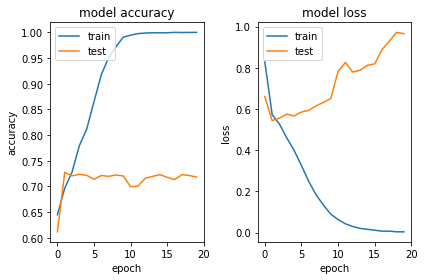

In [39]:
# Fit the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,verbose=1,
                    validation_data=(X_test, y_test), callbacks=[checkpointer])


# Evaluate the model
score = max(history.history['val_acc'])
print("%s: %.2f%%" % (model.metrics_names[1], score*100))
plt = construct.plot_results(history.history)
plt.show()

## Validating predictions on native data

In [10]:
native_data = '/Users/joe.abbott/Documents/dataScience/capstone/ExpressYeaself/example/native_data/native_data.txt.gz'
native_df = pd.read_csv(native_data, sep='\t', keep_default_na=True)
native_df = native_df.dropna()
native_df.head(3)

,seq,isNative,EL.originalHQ,EL.rep1,EL.rep2,EL.combined
0,AACTGCATTTTTTTCACATCAAAAAGCGTCCCATAACCCATTATGG...,False,5.534436,6.015822,3.133565,5.374793
1,AACTGCATTTTTTTCACATCAAAAGCGTAAGTTGCCCCCACGTTTT...,False,12.909398,12.066980,8.914323,11.668808
2,AACTGCATTTTTTTCACATCAACAGTGTGGCGCTGTGTGGTTTCGA...,False,14.201689,12.945028,10.972485,13.682270


In [52]:
test_seq = native_df['seq'][0]
test_seq = test_seq[20:100]
encoded_test_seq = np.array([encode.one_hot_encode_sequence(test_seq)])
# print(native_df['seq'][0])
# print(native_df['seq'][1])
# print(native_df['seq'][2])

In [53]:
prob = model.predict(encoded_test_seq)[0][0]

In [54]:
prob

0.06805472

In [77]:
results = {}
for i in range(0, 100):
    seq = native_df['seq'][i]
    test_seq = seq[20:100]
    encoded_test_seq = np.array([encode.one_hot_encode_sequence(test_seq)])
    prob = model.predict(encoded_test_seq)[0][0]
    results[i] = [seq, prob]

In [78]:
results

{0: ['AACTGCATTTTTTTCACATCAAAAAGCGTCCCATAACCCATTATGGCTGTTATGATAGTATCAGTCGGGGGATCTTAGCGTGTAGGCCTTGGACGTCGGGGGTTACGGCTGTTTCTTAAT',
  0.06805472],
 1: ['AACTGCATTTTTTTCACATCAAAAGCGTAAGTTGCCCCCACGTTTTTCAGCGCTGCTGCGGAAGCGGTGGTTAAGTCGGTCCCCTCTTCGCGATCTTACAGGTTACGGCTGTTTCTTAAT',
  0.9108772],
 2: ['AACTGCATTTTTTTCACATCAACAGTGTGGCGCTGTGTGGTTTCGAGGGGACGGCACGGGGATGAACCCGACTCTAATAGGTCATGCACATCCACATCCTGGTTACGGCTGTTTCTTAAT',
  0.97648925],
 3: ['AACTGCATTTTTTTCACATCAGTAAAGCTCCGTTTCTTCCAGTTTTAGGGTCTGAATTTCGGACCTTTGGGTGCTCCCGTCACATCACGAGAAGCCATACGGTTACGGCTGTTTCTTAAT',
  0.25136235],
 4: ['AACTGCATTTTTTTCACATCAGTAAATCCTTATTTGACGATTACACACTTAACTAGCACCCCTCTTACAAGAGTCTGTTCAGTAGCTGAACAGCGCTGGTGGTTACGGCTGTTTCTTAAT',
  0.002097094],
 5: ['AACTGCATTTTTTTCACATCAGTAACCACCGGGTTCTAGTGCCTGCAATGTTTATATCTGTGGGTTCAAGAGGGATGCGTATGCTCGGCTAGCTCCCGCGGGTTACGGCTGTTTCTTAAT',
  0.91798335],
 6: ['AACTGCATTTTTTTCACATCAGTAACGGGCACAGGTGCTGCCAACATTTCTGTTTATACAAGCAGCTATGGTGCCTGTATAAGGGGTCGAAGTCGGATGGGGTTACGGCTGTTTCTTAAT',
  0.260

In [79]:
predictions = pd.DataFrame.from_dict(results, orient='index', columns=['seq', 'probability'])

In [80]:
predictions.head()

,seq,probability
0,AACTGCATTTTTTTCACATCAAAAAGCGTCCCATAACCCATTATGG...,0.068055
1,AACTGCATTTTTTTCACATCAAAAGCGTAAGTTGCCCCCACGTTTT...,0.910877
2,AACTGCATTTTTTTCACATCAACAGTGTGGCGCTGTGTGGTTTCGA...,0.976489
3,AACTGCATTTTTTTCACATCAGTAAAGCTCCGTTTCTTCCAGTTTT...,0.251362
4,AACTGCATTTTTTTCACATCAGTAAATCCTTATTTGACGATTACAC...,0.002097


In [89]:
sorted_pred = predictions.sort_values('probability', ascending=False).reset_index().drop(columns=['index'])

In [90]:
sorted_pred.head()

,seq,probability
0,AACTGCATTTTTTTCACATCAGTGCGGGGGTCTAGGTCTCAGGTTA...,1.000000
1,AACTGCATTTTTTTCACATCAGTATTAACGTGGCCTACTGTTCTTA...,0.999986
2,AACTGCATTTTTTTCACATCAGTATGTCGTCGCGTGTTGTTTCTAA...,0.999968
3,AACTGCATTTTTTTCACATCAGTGGAATTGTACGGGGCACATCTTA...,0.999919
4,AACTGCATTTTTTTCACATCAGTCCCTCCATCTACCATCAAAAAGT...,0.999831


In [91]:
highest = sorted_pred['seq'][0]
highest

'AACTGCATTTTTTTCACATCAGTGCGGGGGTCTAGGTCTCAGGTTAACTAGTGGATGCGGATGCTGCCGGCCGCGGGCGGTCGCGCTTGACGGGAGAATAGGTTACGGCTGTTTCTTAAT'

In [92]:
native_df.loc[native_df['seq'] == highest]

,seq,isNative,EL.originalHQ,EL.rep1,EL.rep2,EL.combined
87,AACTGCATTTTTTTCACATCAGTGCGGGGGTCTAGGTCTCAGGTTA...,False,15.22599,14.579064,11.657841,14.610094
